Following tutorial from [here](https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python)

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [79]:
from glob import glob

In [123]:
X = []
labels = []

for lcpath, truthpath in zip(sorted(glob('data/parallel_normed/*_simulated_transit_lcs.npy')), 
                             sorted(glob('data/parallel_normed/*_simulated_spots_occulted.npy'))):
    X.append(np.load(lcpath).T)
    labels.append(np.load(truthpath))

X = np.vstack(X)[:, :, np.newaxis] - np.array(X).mean()
X /= X.ptp()
# X += 0.5
labels = np.hstack(labels)#[:, np.newaxis]

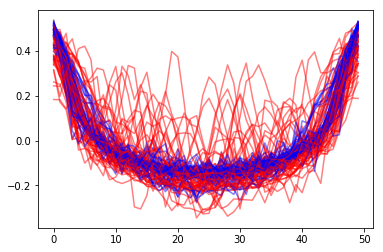

In [124]:
for x, l in zip(X[:100, :], labels):
    plt.plot(x, color='r' if l else 'b', alpha=0.5)

In [125]:
# X = np.random.randn(*X.shape)

In [126]:
# X = np.load('data/simulated_transit_lcs.npy')[:, :, np.newaxis]
# labels = np.load('data/simulated_spots_occulted.npy').astype(int)#[:, np.newaxis]

In [127]:
train_X = X
train_Y = labels

print('Training data shape : ', train_X.shape, train_Y.shape)

# print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (4000, 50, 1) (4000,)


In [128]:
# Find the unique numbers from the train labels
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [False  True]


In [129]:
# train_X = train_X.reshape(-1, 1)
# test_X = test_X.reshape(-1, 1)
train_X.shape#, test_X.shape

(4000, 50, 1)

In [130]:
train_X = train_X.astype('float32')
# test_X = test_X.astype('float32')
# train_X = train_X / 255.
# test_X = test_X / 255.

In [131]:
from keras.utils import to_categorical

train_Y_one_hot = to_categorical(train_Y)
# test_Y_one_hot = to_categorical(test_Y)

In [132]:
from sklearn.model_selection import train_test_split

train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, 
                                                              test_size=0.2, random_state=13)

In [133]:
# plt.plot(train_X[:10, :, 0].T);
# print(np.sum(valid_label, axis=0))

In [134]:
# valid_label = to_categorical(valid_label)
# train_label = to_categorical(train_label)

In [135]:
# for transit, lab in zip(X[:100, :], labels[:100, :]): 
#     if lab: 
#         plt.plot(transit)
#     else: 
#         print('skip')

In [136]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((3200, 50, 1), (800, 50, 1), (3200, 2), (800, 2))

In [137]:
valid_X.shape

(800, 50, 1)

In [138]:
alpha = 0.1
kernel_size = 5
activation = 'linear'
padding = 'same'

batch_size = 128 #64
epochs = 20 #100
num_classes = 2

model = Sequential()

# First layer
model.add(Conv1D(filters=32, kernel_size=kernel_size, activation=activation, 
                 input_shape=(train_X.shape[1], 1), padding=padding))
model.add(LeakyReLU(alpha=alpha))
model.add(MaxPooling1D(2, padding=padding))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Second layer
model.add(Conv1D(filters=64, kernel_size=kernel_size, 
                 activation=activation, padding=padding))
model.add(LeakyReLU(alpha=alpha))
model.add(MaxPooling1D(pool_size=2, padding=padding))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Third layer
model.add(Conv1D(filters=128, kernel_size=kernel_size, 
                 activation=activation, padding=padding))
model.add(LeakyReLU(alpha=alpha))                  
model.add(MaxPooling1D(pool_size=2, padding=padding))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# fourth layer
model.add(Conv1D(filters=128, kernel_size=kernel_size, 
                 activation=activation, padding=padding))
model.add(LeakyReLU(alpha=alpha))                  
model.add(MaxPooling1D(pool_size=2, padding=padding))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# fifth layer
model.add(Conv1D(filters=128, kernel_size=kernel_size, 
                 activation=activation, padding=padding))
model.add(LeakyReLU(alpha=alpha))                  
model.add(MaxPooling1D(pool_size=2, padding=padding))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# sixth layer
model.add(Conv1D(filters=128, kernel_size=kernel_size, 
                 activation=activation, padding=padding))
model.add(LeakyReLU(alpha=alpha))                  
model.add(MaxPooling1D(pool_size=2, padding=padding))
model.add(BatchNormalization())
model.add(Dropout(0.25))

# Fully connected layer 1
model.add(Flatten())
model.add(Dense(128, activation=activation))
model.add(LeakyReLU(alpha=alpha))

# Fully connected layer 2
# model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

In [139]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=keras.optimizers.Adam(),
#               optimizer=keras.optimizers.SGD(lr=1e-4),
              metrics=['accuracy'])
model.summary()
# model.load_weights('data/weights.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_43 (Conv1D)           (None, 50, 32)            192       
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 50, 32)            0         
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 25, 32)            0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 25, 32)            128       
_________________________________________________________________
dropout_43 (Dropout)         (None, 25, 32)            0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 25, 64)            10304     
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 25, 64)            0         
__________

In [140]:
train = model.fit(train_X, train_label, batch_size=batch_size, 
                  epochs=epochs, validation_data=(valid_X, valid_label))

Train on 3200 samples, validate on 800 samples
Epoch 1/20
3200/3200 [==============================] - 4s 1ms/step - loss: 0.6067 - acc: 0.7272 - val_loss: 1.3857 - val_acc: 0.6138
Epoch 2/20
3200/3200 [==============================] - 1s 307us/step - loss: 0.4075 - acc: 0.8259 - val_loss: 0.8730 - val_acc: 0.7375
Epoch 3/20
3200/3200 [==============================] - 1s 302us/step - loss: 0.3332 - acc: 0.8653 - val_loss: 0.7162 - val_acc: 0.7887
Epoch 4/20
3200/3200 [==============================] - 1s 305us/step - loss: 0.2698 - acc: 0.9006 - val_loss: 0.3477 - val_acc: 0.8862
Epoch 5/20
3200/3200 [==============================] - 1s 312us/step - loss: 0.2420 - acc: 0.9122 - val_loss: 0.2891 - val_acc: 0.9075
Epoch 6/20
3200/3200 [==============================] - 1s 340us/step - loss: 0.2227 - acc: 0.9194 - val_loss: 0.2458 - val_acc: 0.9137
Epoch 7/20
3200/3200 [==============================] - 1s 359us/step - loss: 0.2141 - acc: 0.9206 - val_loss: 0.2756 - val_acc: 0.9087
Epo

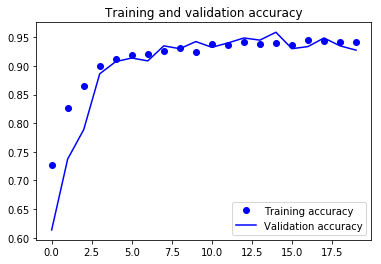

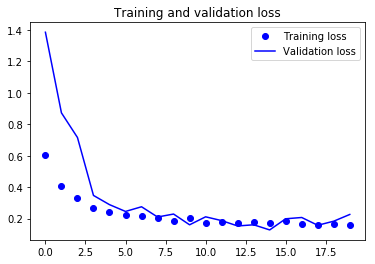

In [141]:
accuracy = train.history['acc']
val_accuracy = train.history['val_acc']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [142]:
model.save('data/model.hdf5')

In [25]:
from keras.utils import plot_model
plot_model(model, to_file='plots/model.pdf', show_layer_names=False)

In [ ]:
# model.save_weights('data/weights.hdf5')

https://www.quora.com/Why-does-my-convolutional-neural-network-always-produce-the-same-outputs: 
> Hey, I had a similar issue with my own (hand-coded) CNN trying to get some results with the CIFAR-10 dataset. What I found was that I had forgotten to normalize the input images to some range that made sense with my weight scales. Try something like X = X / max(abs(X)) to put values between -1 and 1.

> Another possibility is your weight initialization is causing many ReLU units to die. I usually initialize all weights with a small number times a normal Gaussian distribution. For wx+ b, b being the biases, you can try that + a small positive constant. I.e. b = weight_scale*random.randn(num, 1) + 0.1

> Another idea — your sigmoid unit might be squashing your responses too much. They’re fairly uncommon in CNNs from what I understand, maybe just stick to ReLUs.

> Last point — try testing on a small training batch (say 10–20 images) and just train until you overfit with 100% accuracy. That’s one way of knowing that your network is capable of doing something. I think these smaller tests are very important before investing hours or days into proper training, which is what these networks often require.

https://github.com/keras-team/keras/issues/1006

on "deep" networks: https://stats.stackexchange.com/questions/182734/what-is-the-difference-between-a-neural-network-and-a-deep-neural-network-and-w